
This notebook provides an example of using reverse correlation and bubbles method to probe a machine learning classifier.

Here, an SVM with a gaussian kernel is trained to classify MNIST handwritten digits and then the discriminative and prototypical information are revealed with bubbles and reverse correlation.

This notebook serves as a practical support for the course on xAI within the "Machine learning, from prediction to interpretation" Neuroschool Ph.D. program.

Relevant references:
* https://doi.org/10.1371/journal.pcbi.1011849
* https://doi.org/10.1038/s44159-023-00239-z
* https://doi.org/10.1016/j.jneumeth.2021.109297

# Import libraries

In [1]:
!pip install tensorflow # install tensorflow for MNIST

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA

# Local functions

In [9]:
import numpy as np
import random
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# compute the canonical map for a given category (category) from the probed samples (tab) and their classification item (y_pred)
def ComputeOneCanonicalMap(tab,y_pred,category):
	canonicalMap = (np.nanmean(np.asarray(tab[y_pred==category,:]),axis=0)-np.nanmean(np.asarray(tab[y_pred!=category,:]),axis=0))/np.sqrt(1/2*(np.std(np.asarray(tab[y_pred==category,:]),axis=0)**2+np.std(np.asarray(tab[y_pred!=category,:]),axis=0)**2))
	return canonicalMap

# compute the canonical maps for the different categories
def ComputeCanonicalMaps(tab,y_pred,dimOfinput):
	tabMaps = []
	for iCateg in range(np.unique(y_pred).shape[0]):
		category = np.unique(y_pred)[iCateg]
		tabMaps.append(ComputeOneCanonicalMap(tab,y_pred,category))
	return tabMaps

# compute the discriminative map for a given category (category) from the probed samples (tab) and their classification item (y_pred)
def ComputeOneDiscriminativeMap(tab,y_pred,category):
	dprimeTab = np.sum(np.asarray(tab[y_pred==category,:]),axis=0) / (np.sum(np.asarray(tab),axis=0))
	return dprimeTab

# compute the discriminative maps for the different categories
def ComputeDiscriminativeMaps(tab,y_pred,dimOfinput):
	tabMaps = []
	for iCateg in range(np.unique(y_pred).shape[0]):
		category = np.unique(y_pred)[iCateg]
		tabMaps.append(ComputeOneDiscriminativeMap(tab,y_pred,category))
	return tabMaps

# generate the bubble masks
def generateBubbleMask(dimOfinput=(28,28), nbMasks=10, nbBubbles=10, bubbleSize=[4, 4]):
	nFeatures = np.product(dimOfinput) # np.asarray(dimOfinput)[0]*np.asarray(dimOfinput)[1]
	masks = np.random.rand(nbMasks,nFeatures)

	for iSample in range(nbMasks):
	    vec = masks[iSample,:]
	    vec[:] = 0
	    bubblePos = (np.floor(np.random.rand(1,nbBubbles)*nFeatures)).astype(int)
	    vec[bubblePos] = 1
	    vec = np.reshape(vec,dimOfinput)
	    vec = gaussian_filter(vec, sigma=bubbleSize)
	    masks[iSample,:] = vec.flatten()
	    masks[iSample,:] /= np.amax(masks[iSample,:])
	    masks[iSample,:] -= np.amin(masks[iSample,:])
	    masks[iSample,:] /= np.amax(masks[iSample,:])
	return masks

# generate probing samples from training set or with noise, or with pseudo-random noise from a testing set
def generateProbingSamples(x_train_set = [], x_test_set = [], dimOfinput=(28,28), bubbleMasks = [], probingMethod = 'bubbles', samplesMethod = 'gaussianNoise', nDim_pca = 50, nbRevcorTrials = 1000, normalizeNoiseCoeff = 10):
	if probingMethod == 'bubbles':
		N_probing_samples = bubbleMasks.shape[0]
		if samplesMethod == 'pseudoRandom':
			pca_noise = PCA(n_components= nDim_pca, svd_solver='auto', whiten=True).fit(np.reshape(x_test_set,(x_test_set.shape[0],np.product(dimOfinput))))
			probingSamples = pca_noise.inverse_transform(np.random.randn(bubbleMasks.shape[0],nDim_pca)) * bubbleMasks
		elif samplesMethod == 'gaussianNoise':
			probingSamples = np.random.randn(bubbleMasks.shape[0],bubbleMasks.shape[1]) * bubbleMasks
		elif samplesMethod == 'trainSet':
			probingSamples =  np.reshape(x_train_set,(x_train_set.shape[0],np.product(dimOfinput)))[0:bubbleMasks.shape[0],:] * bubbleMasks
	elif probingMethod == 'revcor':
		if samplesMethod == 'pseudoRandom':
			pca_noise = PCA(n_components= nDim_pca, svd_solver='auto', whiten=True).fit(np.reshape(x_test_set,(x_test_set.shape[0],np.product(dimOfinput))))
			probingSamples = pca_noise.inverse_transform(np.random.randn(nbRevcorTrials,nDim_pca))
		elif samplesMethod == 'gaussianNoise':
			probingSamples = np.random.randn(nbRevcorTrials,np.product(dimOfinput))
		elif samplesMethod == 'trainSet':
			probingSamples =  np.reshape(x_train_set,(x_train_set.shape[0],np.product(dimOfinput)))[0:nbRevcorTrials,:]  + np.random.randn(nbRevcorTrials,np.product(dimOfinput)) / normalizeNoiseCoeff
	return probingSamples


# Load MNIST

In [13]:
from re import X
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
categories = range(10)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [15]:
# Making sure that the values are float so that we can get decimal points after division
X_train = np.reshape(X_train.astype('float32'), (X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test  = np.reshape(X_test.astype('float32'), (X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255.
X_test /= 255.
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 784)
Number of images in x_train 60000
Number of images in x_test 10000


# Dimensionality reduction and SVM training

In [6]:
n_components = 10 # number of PCA dimensions

pca = PCA(n_components=n_components, svd_solver='auto', whiten=True).fit(x_train)
x_train_pca = pca.transform(np.asarray(x_train))
print('Explained variance:'+str(np.sum(pca.explained_variance_ratio_)))
print('PCA done with '+str(n_components)+' dimensions')

Explained variance:0.48815188
PCA done with 10 dimensions


In [7]:
# for a sake of rapidity no gridsearch is done on the training set
# a SVM is trained with a Gaussian Kernel (Radial Basis Function)
clf = SVC(kernel='rbf')
clf.fit(x_train_pca, y_train)
print('SVM fit done')

SVM fit done


In [11]:
y_train_pred = clf.predict(pca.transform(x_train))
y_test_pred = clf.predict(pca.transform(x_test))
print("train balanaced accuracy: %0.2f" % (balanced_accuracy_score(y_train,y_train_pred)))
print("test balanaced accuracy: %0.2f" % (balanced_accuracy_score(y_test,y_test_pred)))

testing balanaced accuracy: 0.94
testing balanaced accuracy: 0.94


# Bubbles

## Generate probing samples

<ipython-input-17-d0b632a7ce37>:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  bubbleMasks = generateBubbleMask(dimOfinput=dimOfinput, nbMasks=nbMasks, nbBubbles=nbBubbles, bubbleSize=bubbleSize)
<ipython-input-17-d0b632a7ce37>:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  probingSamples = generateProbingSamples(x_train_set = X_train, x_test_set = X_test, dimOfinput=dimOfinput, bubbleMasks = bubbleMasks, probingMethod = probingMethod, samplesMethod = samplesMethod, nDim_pca = nDim_pca)


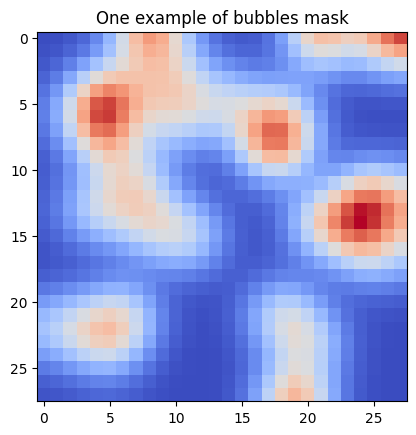

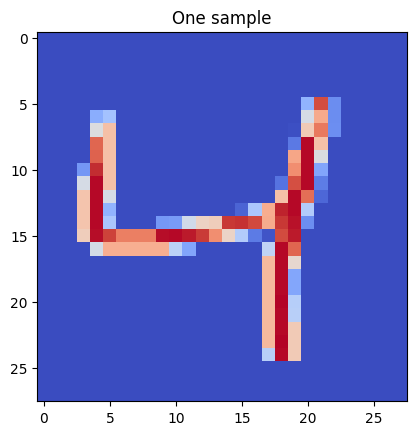

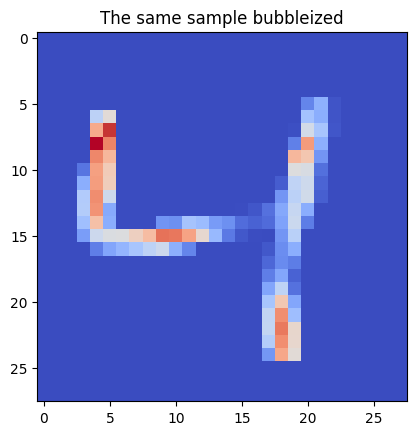

In [17]:
# generate bubbles mask
nbMasks = 10000 # number of trials,
nbBubbles = 30 # number of bubbles
dimOfinput = (28,28) # dimension of the input representation
bubbleSize = [2, 2] # bubbles standards deviations in the different dimensions
bubbleMasks = generateBubbleMask(dimOfinput=dimOfinput, nbMasks=nbMasks, nbBubbles=nbBubbles, bubbleSize=bubbleSize)

# generate probing samples
probingMethod = 'bubbles' # choice of the probing method : bubbles or revcor
samplesMethod = 'trainSet' # choice of the method to generate probing samples trainSet or pseudoRandom (need x_test_set) or gaussianNoise
nDim_pca = 20 # number of dimension to compute the PCA for the pseudo-random noise generation
probingSamples = generateProbingSamples(x_train_set = X_train, x_test_set = X_test, dimOfinput=dimOfinput, bubbleMasks = bubbleMasks, probingMethod = probingMethod, samplesMethod = samplesMethod, nDim_pca = nDim_pca)
probingSamples = np.reshape(probingSamples,(probingSamples.shape[0], 28*28))

# displays
plt.imshow(np.reshape((bubbleMasks[2,:]),(28,28)), cmap='coolwarm')
plt.title('One example of bubbles mask')
plt.show()
plt.imshow(np.reshape((x_train[2,:]),(28,28)), cmap='coolwarm')
plt.title('One sample')
plt.show()
plt.imshow(np.reshape((probingSamples[2,:]),(28,28)), cmap='coolwarm')
plt.title('The same sample bubbleized')
plt.show()
# plt.hist(probingSamples[2,:])
# plt.show()
# plt.hist(x_train[2,:])
# plt.show()
# print(clf.predict(pca.transform(probingSamples[1:10,:])))


## Probe the classifier and compute the discriminative information

(10000, 784)
[5 0 1 ... 6 7 7]


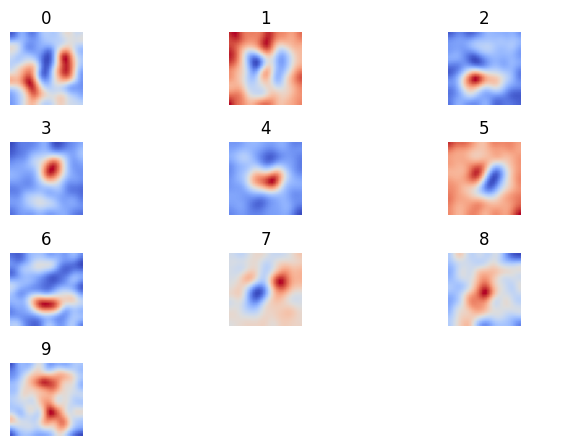

In [ ]:
print(probingSamples.shape)
# compute predictions with the trained classifier
y_pred = clf.predict(pca.transform(probingSamples))
print(y_pred)

# compute discriminative maps
discriminativeMaps = ComputeDiscriminativeMaps(bubbleMasks, y_pred, dimOfinput=dimOfinput)

# plot diagnostic maps
fig, ax = plt.subplots(nrows=4, ncols=3)
for iDigit in range(np.asarray(discriminativeMaps).shape[0]):
	toPlot = np.asarray(discriminativeMaps)[iDigit,:]
	plt.subplot(4,3,iDigit+1)
	im = plt.imshow(np.reshape((toPlot),(28,28)) ,cmap='coolwarm')
	plt.title(str(np.unique(y_pred)[iDigit]))
	plt.xticks([])
	plt.yticks([])
	plt.axis('off')
	plt.tight_layout()
for x in ax.ravel():
    x.axis("off")
plt.savefig('mnist_discriminative.png')
plt.show()

# Reverse correlation

## Generate probing samples

<ipython-input-18-2053678789f3>:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  probingSamples = generateProbingSamples(x_train_set = x_train, x_test_set = x_test, dimOfinput=dimOfinput, probingMethod = probingMethod, samplesMethod = samplesMethod, nDim_pca = nDim_pca, nbRevcorTrials = nbRevcorTrials)


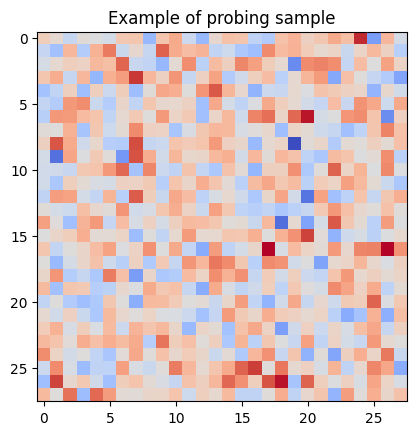

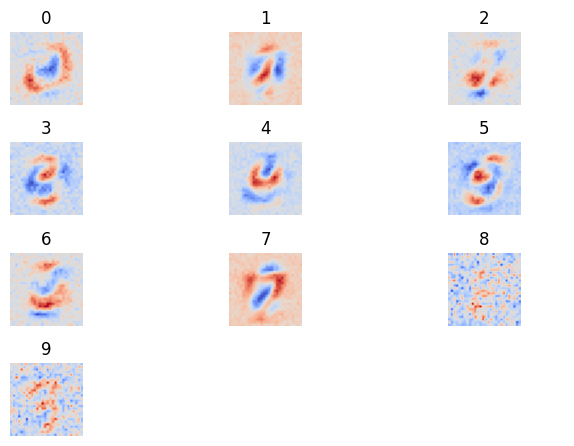

In [18]:
# generate probing samples
dimOfinput = (28,28) # dimension of the input representation
probingMethod = 'revcor' # choice of the probing method : bubbles or revcor
samplesMethod = 'gaussianNoise' # choice of the method to generate probing samples trainSet or pseudoRandom (need x_test_set) or gaussianNoise
nbRevcorTrials = 40000 # number of probing samples for the reverse correlation (must be below the number of training sample if trainSet)
nDim_pca = 50 # number of dimension to compute the PCA for the pseudo-random noise generation
probingSamples = generateProbingSamples(x_train_set = x_train, x_test_set = x_test, dimOfinput=dimOfinput, probingMethod = probingMethod, samplesMethod = samplesMethod, nDim_pca = nDim_pca, nbRevcorTrials = nbRevcorTrials)
probingSamples = np.reshape(probingSamples,(probingSamples.shape[0],28*28))

plt.imshow(np.reshape((probingSamples[2,:]),(28,28)), cmap='coolwarm')
plt.title('Example of probing sample')
plt.show()



## Probe the classifier and compute the prototypical information

In [ ]:

# compute predictions with the trained classifier
y_pred = clf.predict(pca.transform(probingSamples))

canonicalMaps = ComputeCanonicalMaps(probingSamples,y_pred, dimOfinput=dimOfinput)
canonicalMaps_pca = ComputeCanonicalMaps(pca.transform(probingSamples),y_pred, dimOfinput=dimOfinput)

# plot diagnostic maps
fig, ax = plt.subplots(nrows=4, ncols=3)
for iDigit in range(np.asarray(canonicalMaps).shape[0]):
	toPlot = np.asarray(canonicalMaps)[iDigit,:]
	plt.subplot(4,3,iDigit+1)
	im = plt.imshow(np.reshape((toPlot),(28,28)) ,cmap='coolwarm')
	plt.title(str(np.unique(y_pred)[iDigit]))
	plt.xticks([])
	plt.yticks([])
	plt.axis('off')
	plt.tight_layout()
for x in ax.ravel():
    x.axis("off")
plt.savefig('mnist_canonical.png')
plt.show()